<a href="https://colab.research.google.com/github/znirzej/NightToDay/blob/master/VRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%%sh
cp /content/drive/'My Drive'/training.zip . &&
unzip -fq training.zip &&
mkdir training/short/t &&
mkdir training/long/t &&
mv -f training/short/* training/short/t &&
mv -f training/long/* training/long/t

In [0]:
import keras
from keras.layers import *
from keras.layers.merge import concatenate, add
from keras.preprocessing.image import ImageDataGenerator

In [0]:
VALIDATION_PART = 0.2 # TODO

LEARN_SIZE = int(MAX_IMAGES * (1-VALIDATION_PART))
VALIDATION_SIZE = MAX_IMAGES - LEARN_SIZE

dim_x = 512
dim_y = 512

In [37]:
def create_model():
    def conv2d(input, filters):
        xx = Conv2D(filters=filters, kernel_size=(3, 3), activation=tf.nn.relu, padding='same')(input)
        xx = BatchNormalization()(xx)
        xx = tf.layers.Dropout(xx,  0.5) # TODO
        return xx

    def conv2d_up(input, filters):
        return Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(input)

    def max_pool(input):
        return MaxPooling2D((2, 2), strides=2, padding='same')(input)

    input = Input((dim_x, dim_y, 4), name ='img')
    c1 = conv2d(input, 8)
    c1 = conv2d(c1, 8)
    p1 = max_pool(c1)

    c2 = conv2d(p1, 16)
    c2 = conv2d(c2, 16)
    p2 = max_pool(c2)

    c3 = conv2d(p2, 32)
    c3 = conv2d(c3, 32)
    p3 = max_pool(c3)

    c4 = conv2d(p3, 64)
    c4 = conv2d(c4, 64)
    p4 = max_pool(c4)

    c5 = conv2d(p4, 128)
    c5 = conv2d(c5, 128)

    u6 = conv2d_up(c5, 64)
    u6 = concatenate([u6, c4])
    c6 = conv2d(u6, 64)
    c6 = conv2d(c6, 64)

    u7 = conv2d_up(c6, 64)
    u7 = concatenate([u7, c3])
    c7 = conv2d(u7, 32)
    c7 = conv2d(c7, 32)

    u8 = conv2d_up(c7, 16)
    u8 = concatenate([u8, c2])
    c8 = conv2d(u8, 16)
    c8 = conv2d(c8, 32)

    u9 = conv2d_up(c8, 16)
    u9 = concatenate([u9, c1])
    c9 = conv2d(u9, 16)
    c9 = conv2d(c9, 20)

    output = Conv2D(filters=3, kernel_size=(1, 1), activation = None)(c9)

    model = keras.models.Model(inputs=input, outputs=output)
    model.compile(optimizer = keras.optimizers.Adam(1e-4), loss = 'MAE')

    return model

model = create_model()
model.summary()

if False: model = keras.models.load_model('model.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 8)  296         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 512, 512, 8)  32          conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 8)  584         batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [46]:
image_datagen = keras.preprocessing.image.ImageDataGenerator()
mask_datagen = keras.preprocessing.image.ImageDataGenerator()
seed = 1
batch_size = 20

image_generator = image_datagen.flow_from_directory(
    'training/short',
    class_mode=None,
    color_mode='rgba',
    target_size=(dim_x, dim_y),
    batch_size=batch_size,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    'training/long',
    class_mode=None,
    target_size=(dim_x, dim_y),
    batch_size=batch_size,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

Found 142 images belonging to 1 classes.
Found 142 images belonging to 1 classes.


In [47]:
model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=50)

Epoch 1/50
30/30 [==============================] - 14s 481ms/step - loss: 44.8846
Epoch 2/50
30/30 [==============================] - 12s 388ms/step - loss: 41.9700
Epoch 3/50
30/30 [==============================] - 13s 423ms/step - loss: 44.8486
Epoch 4/50
30/30 [==============================] - 12s 411ms/step - loss: 44.4470
Epoch 5/50
30/30 [==============================] - 13s 430ms/step - loss: 41.7054
Epoch 6/50
30/30 [==============================] - 12s 416ms/step - loss: 42.4203
Epoch 7/50
30/30 [==============================] - 13s 418ms/step - loss: 41.4076
Epoch 8/50
30/30 [==============================] - 13s 423ms/step - loss: 40.8372
Epoch 9/50
30/30 [==============================] - 13s 427ms/step - loss: 38.2897
Epoch 10/50
30/30 [==============================] - 12s 413ms/step - loss: 39.8092
Epoch 11/50
30/30 [==============================] - 12s 408ms/step - loss: 38.0185
Epoch 12/50
30/30 [==============================] - 13s 428ms/step - loss: 36.8578
E

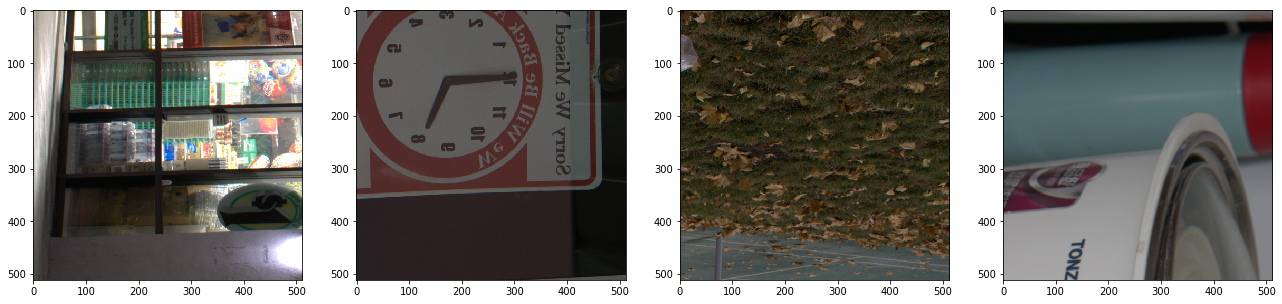

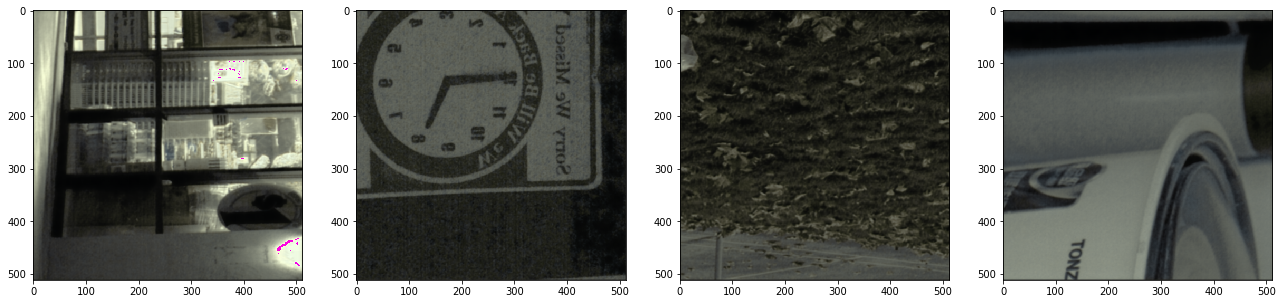

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

x = image_generator.next()
y = mask_generator.next()
pred = model.predict(x)
image = y.astype(np.uint8)
pred = pred.astype(np.uint8)

plt.figure(figsize=(28, 15))
for i in range(4):
  plt.subplot(1, 5, i+1)
  plt.imshow(image[i])
plt.show()

plt.figure(figsize=(28, 15))
for i in range(4):
  plt.subplot(1, 5, i+1)
  plt.imshow(pred[i])
plt.show()


In [0]:
model.save('model.h5')